<a href="https://colab.research.google.com/github/PetrGavrilin/VKR_URFU/blob/main/VKR_part3_LinearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Линейная регрессия</h1>

In [ ]:
# импорт необходимых библиотек
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, ElasticNet, ElasticNetCV
from sklearn.model_selection import RandomizedSearchCV # для поиска при случайном сэмплирование гиперпараметров
from sklearn.model_selection import GridSearchCV

In [ ]:
# Загрузка файла с функциями, как библиотеки
import sys
sys.path.append('/content')
from vkr_function import print_scores, plot_predict, my_test_train_split

In [ ]:
# Загрузка преподготовленных данных
Y = pd.read_csv('/content/flow_rate.csv')
X_tsfel = np.genfromtxt('/content/X_tsfel.csv', delimiter=',')
X_tsfel_savgol = np.genfromtxt('/content/X_tsfel_savgol.csv', delimiter=',')
X_tsfel_rol = np.genfromtxt('/content/X_tsfel_rol.csv', delimiter=',')
borders = pd.read_csv('/content/borders.csv').values.tolist()[0]

Построим модель линейной регрессии на данных, к которым не применялось сглаживание

In [ ]:
Y = np.array(Y['Et'])
X = np.array(X_tsfel)[1:]

In [ ]:
X_train, y_train, X_test, y_test, i_test = my_test_train_split(X, Y, borders)

In [ ]:
#LM = ElasticNetCV(max_iter = 10000)
#LM = Ridge()
LM = LinearRegression()
#LM = RidgeCV()
#LM = SGDRegressor()

In [ ]:
# Обучение модели и вывод метрик
LM.fit(X_train, y_train)
y_predict = LM.predict(X_test)
print_scores(y_test, y_predict)


Ошибка на тестовых данных
MSE: 0.00152
RMSE: 0.03895
R2 : 0.99707


In [ ]:
y_predict_all = LM.predict(X)
print_scores(Y, y_predict_all, False)

Ошибка на полных данных
MSE: 0.00119
RMSE: 0.03450
R2 : 0.99770


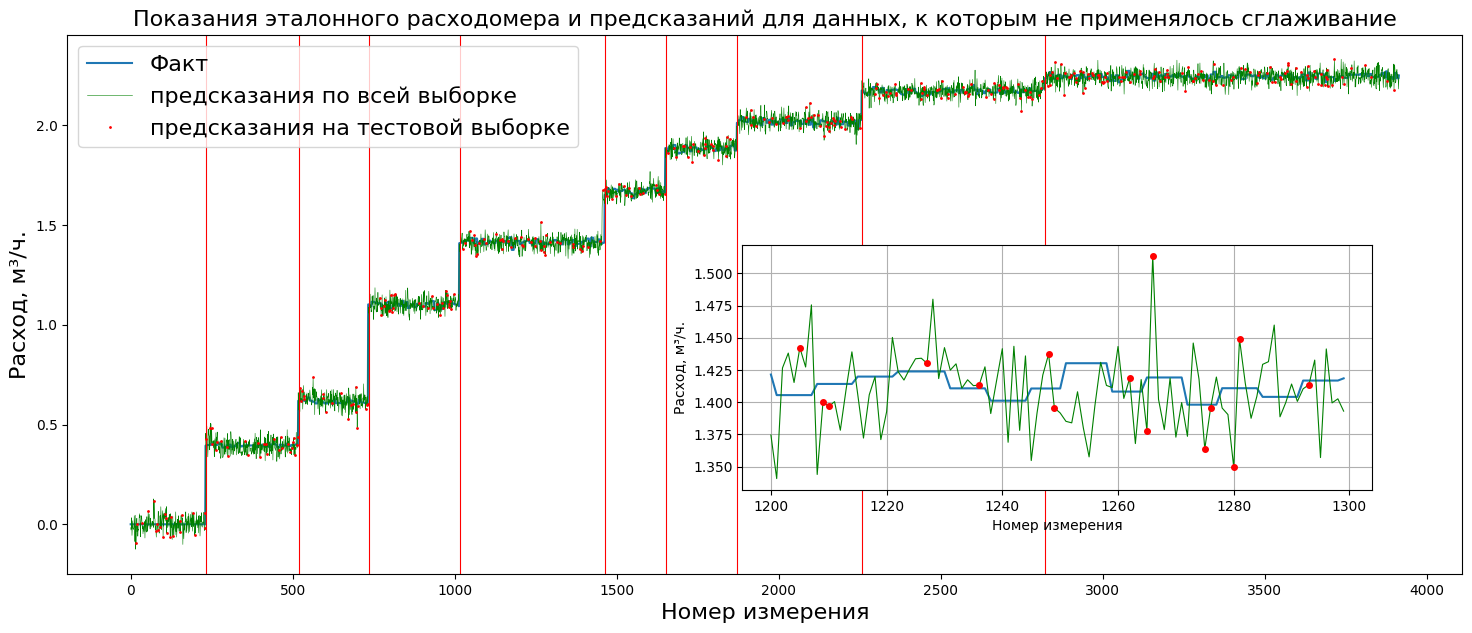

In [ ]:
plot_predict(Y, i_test, y_predict, y_predict_all, borders, text="данных, к которым не применялось сглаживание")

Из колебаний графика предсказаний вокруг фактических данных, а также учитывая построенный ранее график из исходных данных по разности времён, можно предположить, что для исключения колебаний показания расхода необходимо применить сглаживание к исходным данным.

Обучение модели на дополнительно обработанных данных с помощью функции Савицкого-Голея

In [ ]:
X = np.array(X_tsfel_savgol)[1:]


In [ ]:
X_train, y_train, X_test, y_test, i_test = my_test_train_split(X, Y, borders)

In [ ]:
# Обучение модели и вывод метрик
LM.fit(X_train, y_train)
y_predict = LM.predict(X_test)
print_scores(y_test, y_predict)

Ошибка на тестовых данных
MSE: 0.00025
RMSE: 0.01597
R2 : 0.99951


In [ ]:
y_predict_all = LM.predict(X)
print_scores(Y, y_predict_all, False)

Ошибка на полных данных
MSE: 0.00027
RMSE: 0.01649
R2 : 0.99947


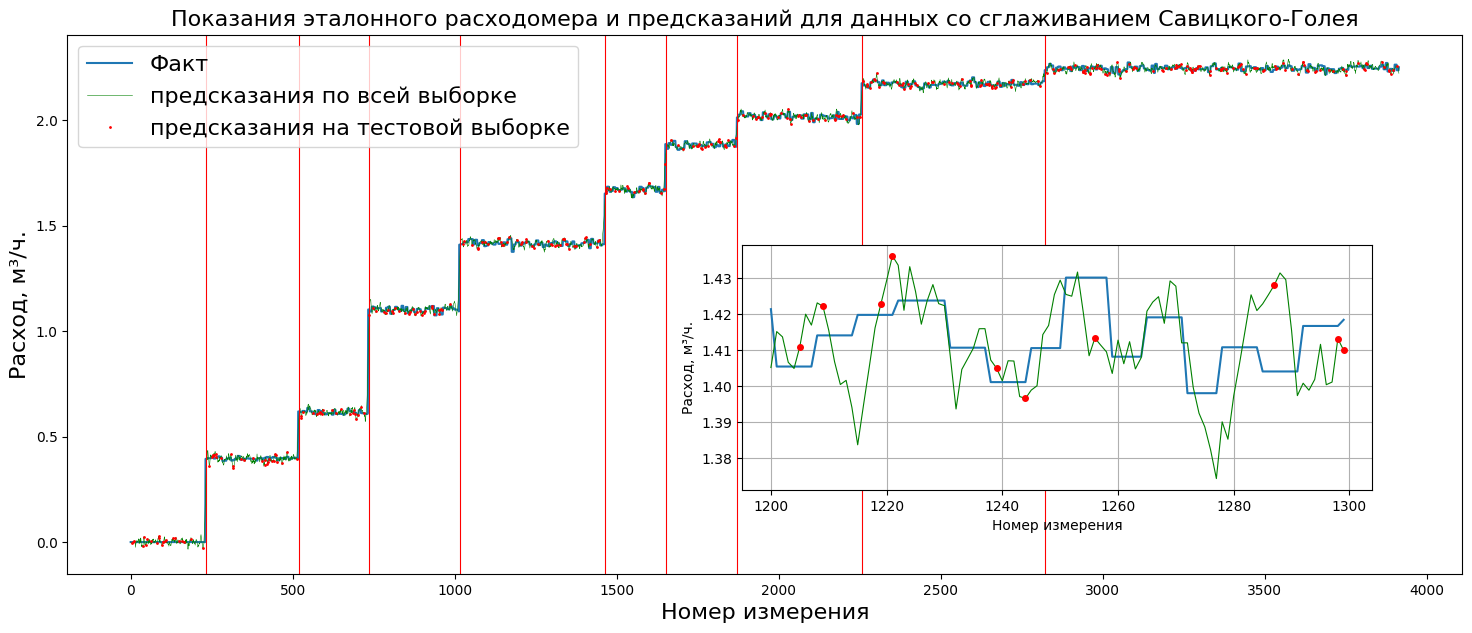

In [ ]:
plot_predict(Y, i_test, y_predict, y_predict_all, borders, text="данных со сглаживанием Савицкого-Голея")

Проверим работу модели, приняв за тестовую выборку один из режимов расхода

In [ ]:
l_ = len(Y)

i_test = list(range(borders[3],borders[4]))

i_train = list(range(0,l_))
for x1 in i_test:
  i_train.remove(x1)

X_train = X[i_train,:]
y_train = Y[i_train]

X_test = X[i_test,:]
y_test = Y[i_test]

print(len(X_train), len(y_train))

3466 3466


In [ ]:
# Обучение модели и вывод метрик
LM.fit(X_train, y_train)
y_predict = LM.predict(X_test)
print_scores(y_test, y_predict)

Ошибка на тестовых данных
MSE: 0.00209
RMSE: 0.04572
R2 : -7.05204


In [ ]:
y_predict = LM.predict(X_test)
print_scores(y_test, y_predict)

Ошибка на тестовых данных
MSE: 0.00209
RMSE: 0.04572
R2 : -7.05204


In [ ]:
y_predict_all = LM.predict(X)
print_scores(Y, y_predict_all, False)

Ошибка на полных данных
MSE: 0.00043
RMSE: 0.02071
R2 : 0.99917


In [ ]:
LM.get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}

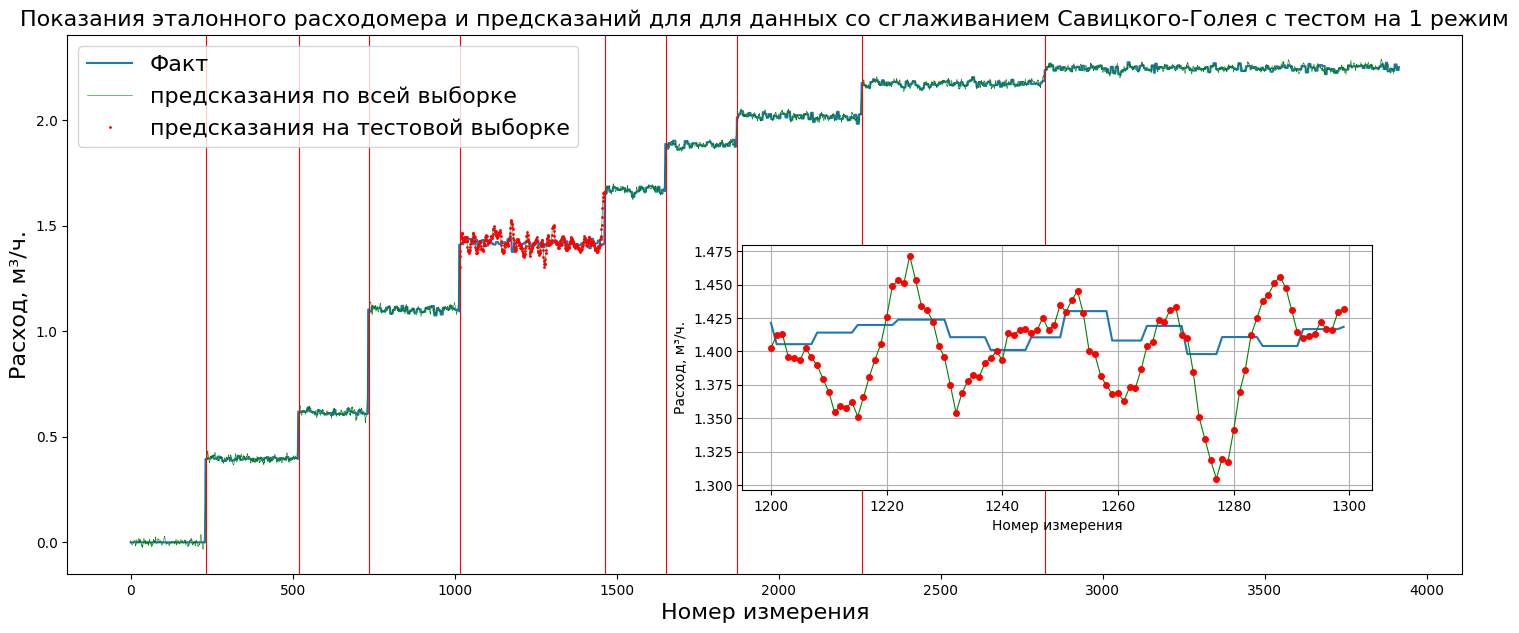

In [ ]:
plot_predict(Y, i_test, y_predict, y_predict_all, borders, text="для данных со сглаживанием Савицкого-Голея с тестом на 1 режим")

In [ ]:
Y[1015:1464].sum()/(1464-1015)

1.4169322693003341

In [ ]:
y_predict_all[1015:1464].sum()/(1464-1015)

1.4225035503688015

Построим линейную модель для данных со скользящим средним

In [ ]:
X = np.array(X_tsfel_rol)[1:]

In [ ]:
X_train, y_train, X_test, y_test, i_test = my_test_train_split(X, Y, borders)

In [ ]:
# Обучение модели и вывод метрик
LM.fit(X_train, y_train)
y_predict = LM.predict(X_test)
print_scores(y_test, y_predict)

Ошибка на тестовых данных
MSE: 0.00062
RMSE: 0.02490
R2 : 0.99880


In [ ]:
y_predict_all = LM.predict(X)
print_scores(Y, y_predict_all, False)

Ошибка на полных данных
MSE: 0.00041
RMSE: 0.02022
R2 : 0.99921


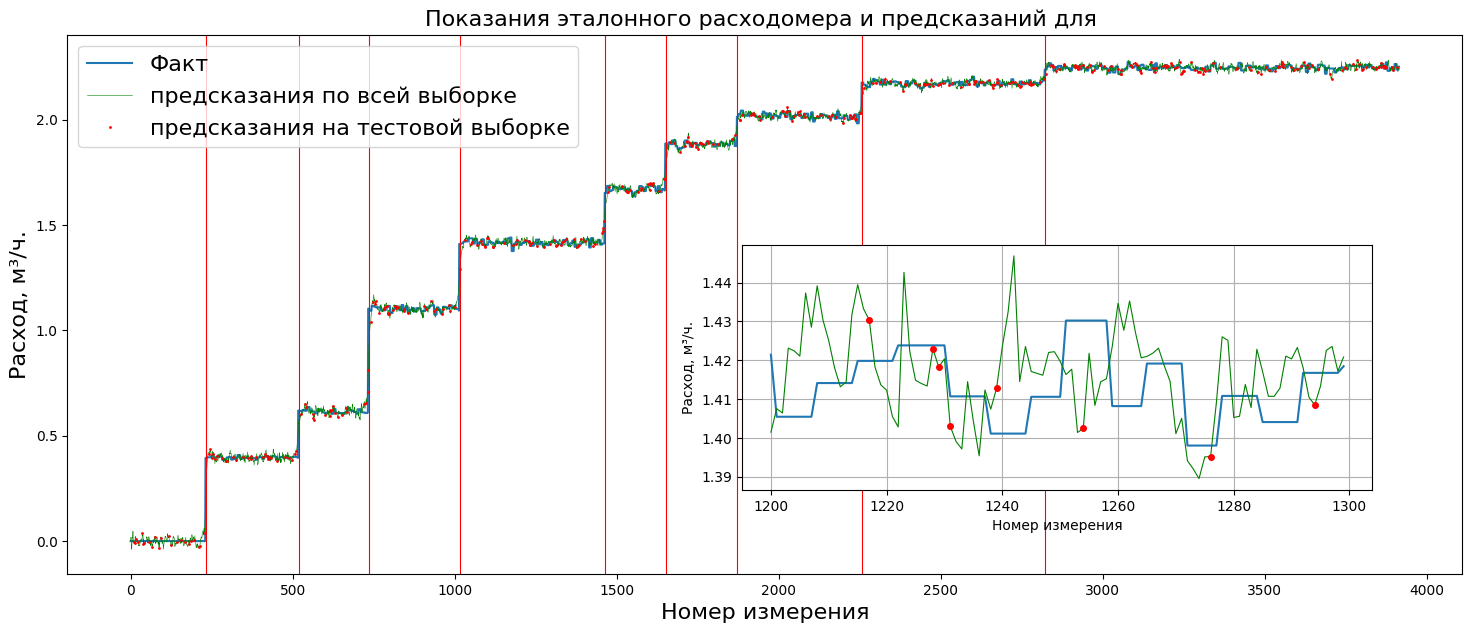

In [ ]:
plot_predict(Y, i_test, y_predict, y_predict_all, borders, text="")